# Emails Data Extraction and Analysis
This notebook extracts labeled emails data from Enron-Spam dataset (https://www.kaggle.com/datasets/wanderfj/enron-spam) for spam detection task. This dataset is divided into 6 parts: in each of the first 3 parts there are approximately 6000 emails in which one fourth are spam, while in each of the last 3 parts there are approximately 6000 emails in which one fourth are legitimate. A more precise analysis is presented in the following code.
Also, the emails are cleaned in many different ways, in order to allows the feature extractors to give better results in the classification algorithms.

### Imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from wordcloud import WordCloud
from random import shuffle, randint
import os
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matteobassani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matteobassani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matteobassani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/matteobassani/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/matteobassani/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Importing Raw Dataset
Emails are distinguished between:
- **HAM**: intended or safe legitimate messages in a mailbox.
- **SPAM**: unsolicited messages with commercial and malicious intent.

In [35]:
ham_emails = []
spam_emails = []

# Emails are read from the file system and saved in one of the two lists
for root, directories, files in os.walk("dataset_enron"):
    for file_name in files:
        if 'ham' in file_name:
            with open(os.path.join(root, file_name), encoding='latin1') as f:
                ham_emails.append(" ".join(f.readlines()))
        elif 'spam' in file_name:
            with open(os.path.join(root, file_name), encoding='latin1') as f:
                spam_emails.append(" ".join(f.readlines()))

# Remove all redundent data
ham_emails = list(set(ham_emails))
spam_emails = list(set(spam_emails))

In [36]:
# 10 ham examples
ham_emails[0:10]

["Subject: organizational announcement\n it is with regret that i have to announce that jeff skilling is leaving enron . today , the board of directors accepted his resignation as president and ceo of enron . jeff is resigning for personal reasons and his decision is voluntary . i regret his decision , but i accept and understand it . i have worked closely with jeff for more than 15 years , including 11 here at enron , and have had few , if any , professional relationships that i value more . i am pleased to say that he has agreed to enter into a consulting arrangement with the company to advise me and the board of directors .\n now it ' s time to look forward .\n with jeff leaving , the board has asked me to resume the responsibilities of president and ceo in addition to my role as chairman of the board . i have agreed . i want to assure you that i have never felt better about the prospects for the company . all of you know that our stock price has suffered substantially over the last

In [37]:
# 10 spam examples
spam_emails[0:10]

['Subject: all graphics software available , cheap oem versions .\n good morning ,\n we we offer latest oem packages of all graphics and publishing software from corei , macromedia , adobe and others .\n $ 80 adobe photoshop 8 . 0 / cs\n $ 140 macromedia studio mx 2004\n $ 120 adobe acrobat 7 . 0 professionai\n $ 150 adobe premiere pro 1 . 5\n $ 90 corei desiqner 10\n $ 90 quickbooks 2004 professional edition\n $ 75 adobe paqemaker 7 . 0\n $ 70 xara x vl . 1\n $ 75 adobe audition 1 . 5\n $ 90 discreet 3 d studio max 7\n $ 115 adobe goiive cs\n $ 135 adobe after effects 6 . 5 standard\n $ 45 adobe premiere eiements\n $ 125 corei painter lx\n $ 80 adobe lliustrator cs\n $ 80 adobe lndesiqn cs\n $ 240 adobe creative suite\n $ 140 adobe framemaker 7 . 1\n $ 50 ulead cooi 3 d production studio 1 . 0 . 1\n $ 90 alias motion builder 6 professional\n $ 30 quicken 2004 premier home & biz\n $ 30 adobe photoshop elements 3 . 0\n $ 110 adobe premiere pro 7 . 0\n learn more . . .\n sincerely ,\n kr

In [38]:
all_emails = []
labels = []

# Emails and corresponded  labels are put together
all_emails.extend(ham_emails)
labels.extend(["ham"] * len(ham_emails))
all_emails.extend(spam_emails)
labels.extend(["spam"] * len(spam_emails))

# A dataframe is initialized with the emails data
dataset = pd.DataFrame({"email": all_emails, "label": labels})
# Lenght of the emails information is added to the dataframe
dataset['length'] = dataset['email'].str.len()

dataset.head(5)

,email,label,length
0,Subject: organizational announcement\n it is w...,ham,1724
1,Subject: re : tw ios posting privileged & conf...,ham,1192
2,Subject: meter # 1591 lamay gaslift\n daren - ...,ham,1097
3,"Subject: re : durasoft - - java class\n siva ,...",ham,1761
4,"Subject: transwestern invoice\n elizabeth ,\n ...",ham,3338


In [39]:
# Basic information about the dataset is printed
print("Shape of dataset:")
print(dataset.shape)
print("\nCount of emails:\n",dataset['label'].value_counts())

Shape of dataset:
(30493, 3)

Count of emails:
 ham     15910
spam    14583
Name: label, dtype: int64


In [40]:
# A random email is printed
rand_index = randint(0,dataset.shape[0]-1)
print(dataset.loc[rand_index]['label'] + " email\n")
print(dataset.loc[rand_index]['email'])

ham email

Subject: start date : 1 / 5 / 02 ; hourahead hour : 12 ;
 start date : 1 / 5 / 02 ; hourahead hour : 12 ; no ancillary schedules awarded . no variances detected .
 log messages :
 parsing file - - > > o : \ portland \ westdesk \ california scheduling \ iso final schedules \ 2002010512 . txt


## Dataset Pre-Processing
Since the dataset in raw form, we first have to preprocess it to make it more optimized.

### 1. Data Cleaning
To clean the email text we need to:
- remove hyperlinks
- lowercase the text
- remove numbers
- remove punctuation
- remove whitespaces in excess
- remove newlines

In [41]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

In [42]:
def to_lower(word):
    result = word.lower()
    return result

In [43]:
def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

In [44]:
def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

In [45]:
def remove_whitespace(word):
    result = word.strip()
    return result

In [46]:
def replace_newline(word):
    return word.replace('\n','')

In [47]:
def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,
                      remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

In [48]:
dataset['clean_email_text'] = x_train = [clean_up_pipeline(o) for o in dataset['email']]

dataset.head(5)

,email,label,length,clean_email_text
0,Subject: organizational announcement\n it is w...,ham,1724,subject organizational announcement it is with...
1,Subject: re : tw ios posting privileged & conf...,ham,1192,subject re tw ios posting privileged confide...
2,Subject: meter # 1591 lamay gaslift\n daren - ...,ham,1097,subject meter lamay gaslift daren meter ha...
3,"Subject: re : durasoft - - java class\n siva ,...",ham,1761,subject re durasoft java class siva i will...
4,"Subject: transwestern invoice\n elizabeth ,\n ...",ham,3338,subject transwestern invoice elizabeth thanks...


### 2. Tokenization
With tokenization we transform a text into a sequence (list) of words.

In [49]:
# Function to apply tokenization
def tokenize(text):
    # Split text into tokens using regular expression
    tokens = re.split("\W+", text)
    return tokens

dataset["tokenized_email_text"] = dataset["clean_email_text"].apply(tokenize)

dataset.head(5)

,email,label,length,clean_email_text,tokenized_email_text
0,Subject: organizational announcement\n it is w...,ham,1724,subject organizational announcement it is with...,"[subject, organizational, announcement, it, is..."
1,Subject: re : tw ios posting privileged & conf...,ham,1192,subject re tw ios posting privileged confide...,"[subject, re, tw, ios, posting, privileged, co..."
2,Subject: meter # 1591 lamay gaslift\n daren - ...,ham,1097,subject meter lamay gaslift daren meter ha...,"[subject, meter, lamay, gaslift, daren, meter,..."
3,"Subject: re : durasoft - - java class\n siva ,...",ham,1761,subject re durasoft java class siva i will...,"[subject, re, durasoft, java, class, siva, i, ..."
4,"Subject: transwestern invoice\n elizabeth ,\n ...",ham,3338,subject transwestern invoice elizabeth thanks...,"[subject, transwestern, invoice, elizabeth, th..."


### 3. Removing Stopwords
NLTK (Natural Language Toolkit) is used to remove/filter out the stopwords (useless words).

In [50]:
stopwords = nltk.corpus.stopwords.words("english")

# Function to remove stopwords
def remove_stopwords(tokens):
    tokens_without_stopwords = [token for token in tokens if token not in stopwords]
    return tokens_without_stopwords

dataset["nonstop_email_text"] = dataset["tokenized_email_text"].apply(remove_stopwords)

dataset.head(5)

,email,label,length,clean_email_text,tokenized_email_text,nonstop_email_text
0,Subject: organizational announcement\n it is w...,ham,1724,subject organizational announcement it is with...,"[subject, organizational, announcement, it, is...","[subject, organizational, announcement, regret..."
1,Subject: re : tw ios posting privileged & conf...,ham,1192,subject re tw ios posting privileged confide...,"[subject, re, tw, ios, posting, privileged, co...","[subject, tw, ios, posting, privileged, confid..."
2,Subject: meter # 1591 lamay gaslift\n daren - ...,ham,1097,subject meter lamay gaslift daren meter ha...,"[subject, meter, lamay, gaslift, daren, meter,...","[subject, meter, lamay, gaslift, daren, meter,..."
3,"Subject: re : durasoft - - java class\n siva ,...",ham,1761,subject re durasoft java class siva i will...,"[subject, re, durasoft, java, class, siva, i, ...","[subject, durasoft, java, class, siva, check, ..."
4,"Subject: transwestern invoice\n elizabeth ,\n ...",ham,3338,subject transwestern invoice elizabeth thanks...,"[subject, transwestern, invoice, elizabeth, th...","[subject, transwestern, invoice, elizabeth, th..."


### 4a. Stemming

Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the language.

In [51]:
# Stemmer object from nltk is initialized
porter_stemmer = nltk.PorterStemmer()

# Function to apply stemming
def stemming(tokens):
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return stemmed_tokens

dataset["stemmed_email_text"] = dataset["nonstop_email_text"].apply(stemming)

dataset.head(5)

,email,label,length,clean_email_text,tokenized_email_text,nonstop_email_text,stemmed_email_text
0,Subject: organizational announcement\n it is w...,ham,1724,subject organizational announcement it is with...,"[subject, organizational, announcement, it, is...","[subject, organizational, announcement, regret...","[subject, organiz, announc, regret, announc, j..."
1,Subject: re : tw ios posting privileged & conf...,ham,1192,subject re tw ios posting privileged confide...,"[subject, re, tw, ios, posting, privileged, co...","[subject, tw, ios, posting, privileged, confid...","[subject, tw, io, post, privileg, confidenti, ..."
2,Subject: meter # 1591 lamay gaslift\n daren - ...,ham,1097,subject meter lamay gaslift daren meter ha...,"[subject, meter, lamay, gaslift, daren, meter,...","[subject, meter, lamay, gaslift, daren, meter,...","[subject, meter, lamay, gaslift, daren, meter,..."
3,"Subject: re : durasoft - - java class\n siva ,...",ham,1761,subject re durasoft java class siva i will...,"[subject, re, durasoft, java, class, siva, i, ...","[subject, durasoft, java, class, siva, check, ...","[subject, durasoft, java, class, siva, check, ..."
4,"Subject: transwestern invoice\n elizabeth ,\n ...",ham,3338,subject transwestern invoice elizabeth thanks...,"[subject, transwestern, invoice, elizabeth, th...","[subject, transwestern, invoice, elizabeth, th...","[subject, transwestern, invoic, elizabeth, tha..."


### 4b. Lemmatization

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meanings to one word. We can use it as an alternative of stemming.

In [52]:
# Stemmer object from nltk is initialized
wordnet_lemmatizer = nltk.WordNetLemmatizer()

# Function to apply lemmatization
def lemmatize(tokens):
    lemmatized_tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

dataset["lemmatized_email_text"] = dataset["nonstop_email_text"].apply(lemmatize)

dataset.head(5)

,email,label,length,clean_email_text,tokenized_email_text,nonstop_email_text,stemmed_email_text,lemmatized_email_text
0,Subject: organizational announcement\n it is w...,ham,1724,subject organizational announcement it is with...,"[subject, organizational, announcement, it, is...","[subject, organizational, announcement, regret...","[subject, organiz, announc, regret, announc, j...","[subject, organizational, announcement, regret..."
1,Subject: re : tw ios posting privileged & conf...,ham,1192,subject re tw ios posting privileged confide...,"[subject, re, tw, ios, posting, privileged, co...","[subject, tw, ios, posting, privileged, confid...","[subject, tw, io, post, privileg, confidenti, ...","[subject, tw, io, posting, privileged, confide..."
2,Subject: meter # 1591 lamay gaslift\n daren - ...,ham,1097,subject meter lamay gaslift daren meter ha...,"[subject, meter, lamay, gaslift, daren, meter,...","[subject, meter, lamay, gaslift, daren, meter,...","[subject, meter, lamay, gaslift, daren, meter,...","[subject, meter, lamay, gaslift, daren, meter,..."
3,"Subject: re : durasoft - - java class\n siva ,...",ham,1761,subject re durasoft java class siva i will...,"[subject, re, durasoft, java, class, siva, i, ...","[subject, durasoft, java, class, siva, check, ...","[subject, durasoft, java, class, siva, check, ...","[subject, durasoft, java, class, siva, check, ..."
4,"Subject: transwestern invoice\n elizabeth ,\n ...",ham,3338,subject transwestern invoice elizabeth thanks...,"[subject, transwestern, invoice, elizabeth, th...","[subject, transwestern, invoice, elizabeth, th...","[subject, transwestern, invoic, elizabeth, tha...","[subject, transwestern, invoice, elizabeth, th..."


In [53]:
print(dataset['stemmed_email_text'])

0        [subject, organiz, announc, regret, announc, j...
1        [subject, tw, io, post, privileg, confidenti, ...
2        [subject, meter, lamay, gaslift, daren, meter,...
3        [subject, durasoft, java, class, siva, check, ...
4        [subject, transwestern, invoic, elizabeth, tha...
                               ...                        
30488    [subject, keep, life, absolut, incred, feel, e...
30489    [subject, purchas, uncollect, judici, judgment...
30490    [subject, naughti, cunt, lap, teen, warn, us, ...
30491    [subject, profession, advertis, dear, projecth...
30492    [subject, pharmaceut, draught, gothic, cheapes...
Name: stemmed_email_text, Length: 30493, dtype: object


## Dataset Analysis
To find trends and patterns in this dataset, we perform a dataset analysis.


In [54]:
# Creating a new copy of the dataframe for data analysis only
data_analysis=pd.DataFrame.copy(dataset, deep=True)

In [55]:
# New column are added for data analysis
data_analysis['original_text_length'] = data_analysis["email"].str.len()
data_analysis['clean_text_length'] = data_analysis["clean_email_text"].str.len()
data_analysis['num_characters'] = data_analysis['email'].apply(len)
data_analysis['num_words'] = data_analysis['email'].apply(lambda x:len(nltk.word_tokenize(x)))
data_analysis['num_sentences'] = data_analysis['email'].apply(lambda x:len(nltk.sent_tokenize(x)))
data_analysis.head(5)

,email,label,length,clean_email_text,tokenized_email_text,nonstop_email_text,stemmed_email_text,lemmatized_email_text,original_text_length,clean_text_length,num_characters,num_words,num_sentences
0,Subject: organizational announcement\n it is w...,ham,1724,subject organizational announcement it is with...,"[subject, organizational, announcement, it, is...","[subject, organizational, announcement, regret...","[subject, organiz, announc, regret, announc, j...","[subject, organizational, announcement, regret...",1724,1674,1724,336,19
1,Subject: re : tw ios posting privileged & conf...,ham,1192,subject re tw ios posting privileged confide...,"[subject, re, tw, ios, posting, privileged, co...","[subject, tw, ios, posting, privileged, confid...","[subject, tw, io, post, privileg, confidenti, ...","[subject, tw, io, posting, privileged, confide...",1192,1114,1192,244,13
2,Subject: meter # 1591 lamay gaslift\n daren - ...,ham,1097,subject meter lamay gaslift daren meter ha...,"[subject, meter, lamay, gaslift, daren, meter,...","[subject, meter, lamay, gaslift, daren, meter,...","[subject, meter, lamay, gaslift, daren, meter,...","[subject, meter, lamay, gaslift, daren, meter,...",1097,912,1097,285,16
3,"Subject: re : durasoft - - java class\n siva ,...",ham,1761,subject re durasoft java class siva i will...,"[subject, re, durasoft, java, class, siva, i, ...","[subject, durasoft, java, class, siva, check, ...","[subject, durasoft, java, class, siva, check, ...","[subject, durasoft, java, class, siva, check, ...",1761,1568,1761,403,23
4,"Subject: transwestern invoice\n elizabeth ,\n ...",ham,3338,subject transwestern invoice elizabeth thanks...,"[subject, transwestern, invoice, elizabeth, th...","[subject, transwestern, invoice, elizabeth, th...","[subject, transwestern, invoic, elizabeth, tha...","[subject, transwestern, invoice, elizabeth, th...",3338,2850,3338,766,45


In [56]:
# Information on this dataframe
data_analysis[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,30493.000000,30493.000000,30493.000000
mean,1509.692159,308.223658,18.657364
std,4160.238422,821.776620,56.031202
min,10.000000,2.000000,1.000000
25%,360.000000,74.000000,5.000000
50%,737.000000,156.000000,10.000000
75%,1591.000000,333.000000,19.000000
max,230145.000000,45454.000000,3093.000000


In [57]:
# Information only for ham
data_analysis[data_analysis['label'] == 'ham'][['num_characters','num_words','num_sentences']].describe()


,num_characters,num_words,num_sentences
count,15910.000000,15910.000000,15910.000000
mean,1659.482841,348.440541,18.907794
std,5439.578326,1075.162334,64.959699
min,13.000000,3.000000,1.000000
25%,355.000000,75.000000,4.000000
50%,815.000000,176.000000,9.000000
75%,1711.000000,370.000000,18.000000
max,230145.000000,45454.000000,2827.000000


In [58]:
# Information only for spam
data_analysis[data_analysis['label'] == 'spam'][['num_characters','num_words','num_sentences']].describe()


,num_characters,num_words,num_sentences
count,14583.000000,14583.000000,14583.000000
mean,1346.271069,264.347185,18.384146
std,1964.309314,383.764069,44.283108
min,10.000000,2.000000,1.000000
25%,365.000000,73.000000,5.000000
50%,671.000000,139.000000,10.000000
75%,1420.000000,279.000000,20.000000
max,31407.000000,8403.000000,3093.000000


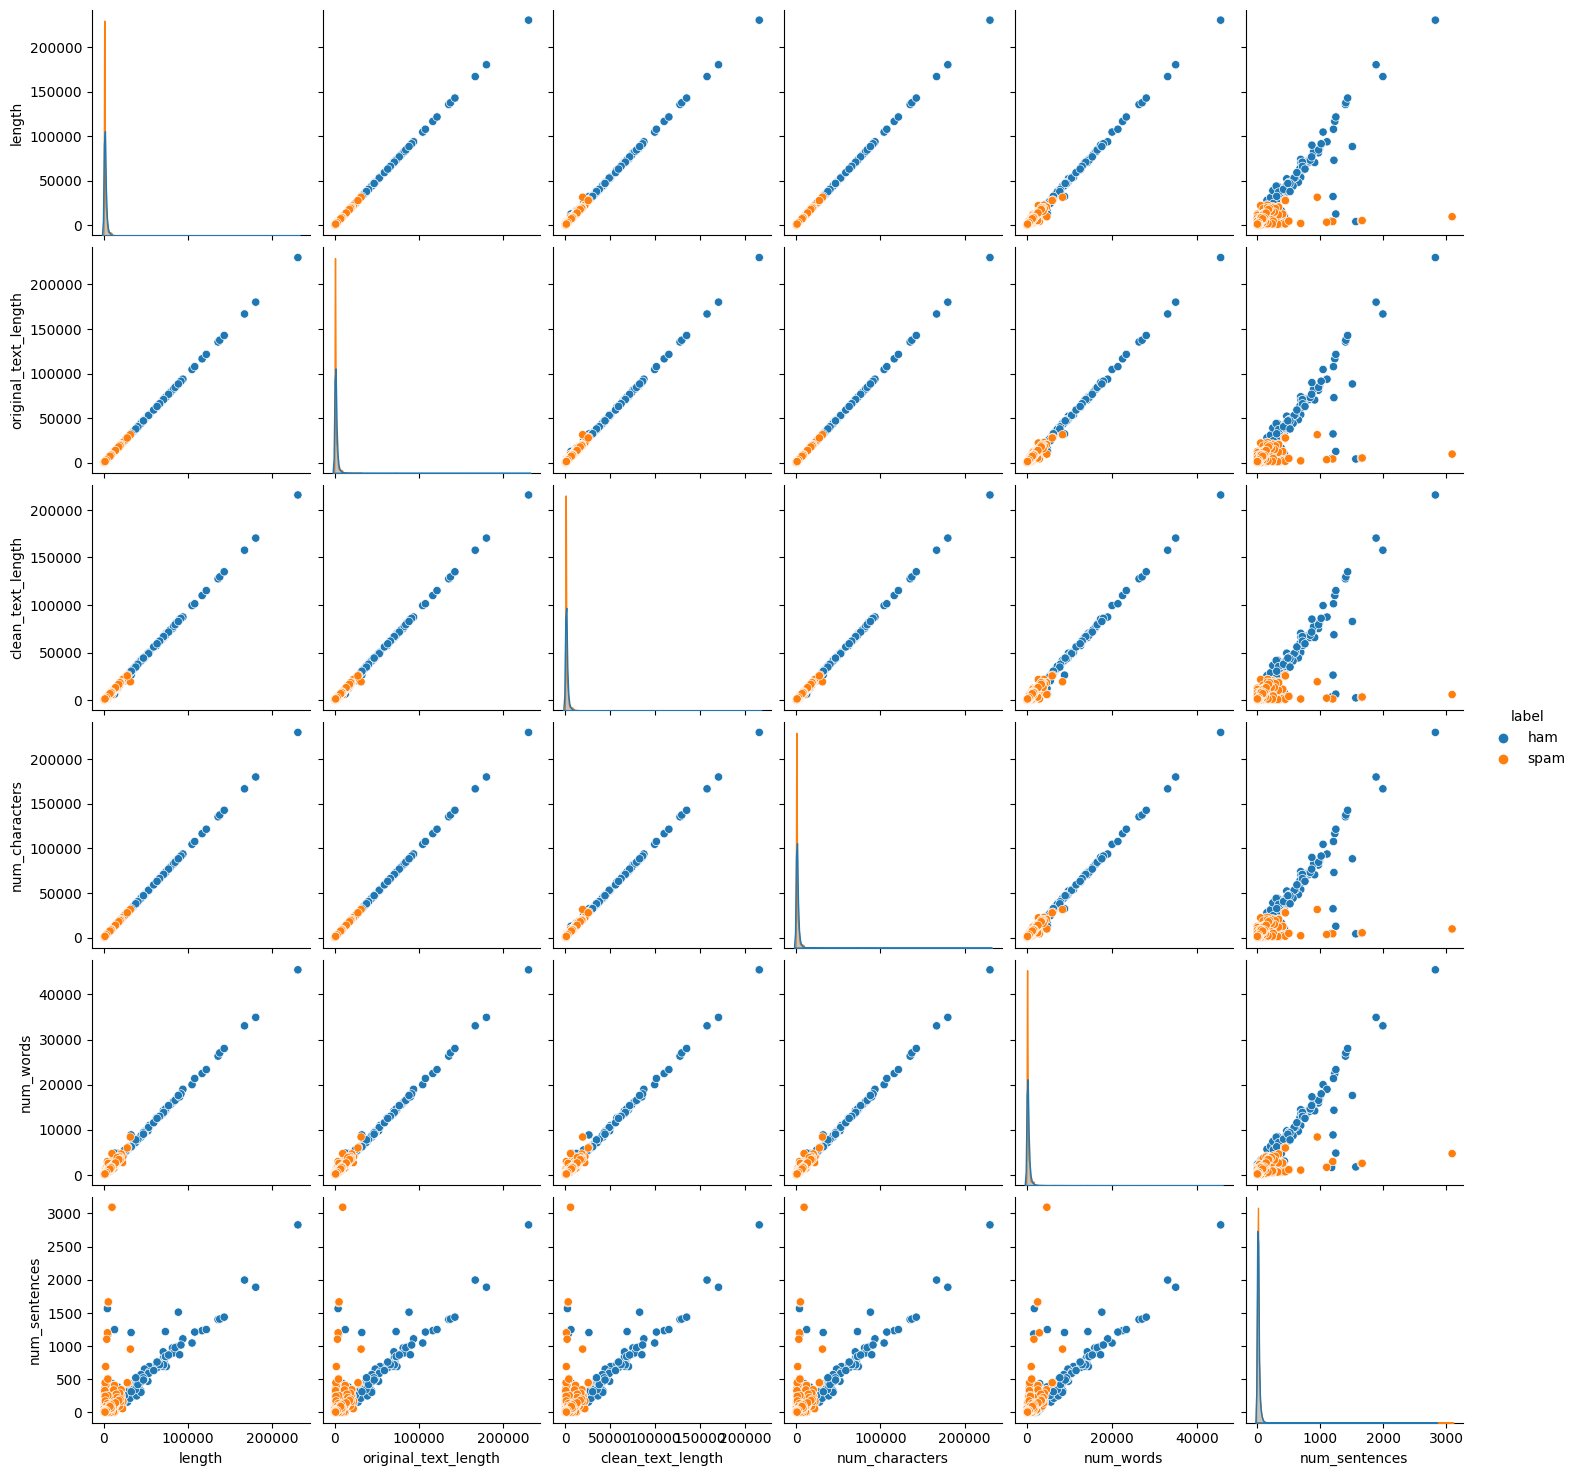

In [59]:
# Pairwise relaction are printed. As we can see spam emails are typically shorter than ham ones
sns.pairplot(data_analysis,hue='label')

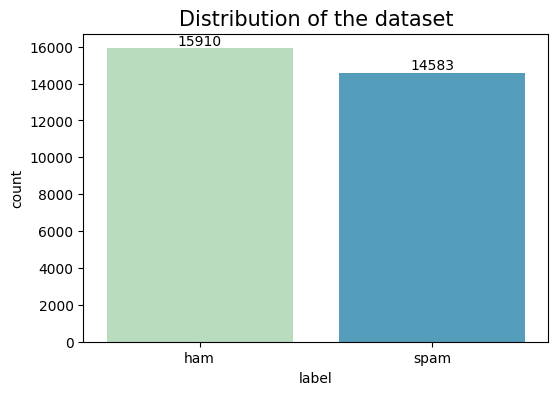

ham     15910
spam    14583
Name: label, dtype: int64


In [60]:
# Counting and plottingnumber of labels
plt.figure(figsize=(6,4))
g=sns.countplot(x=data_analysis['label'],palette= 'GnBu')
plt.title("Distribution of the dataset",fontsize=15)
plt.xticks(rotation='horizontal')
g.bar_label(g.containers[0])
plt.show()
print(data_analysis.label.value_counts())

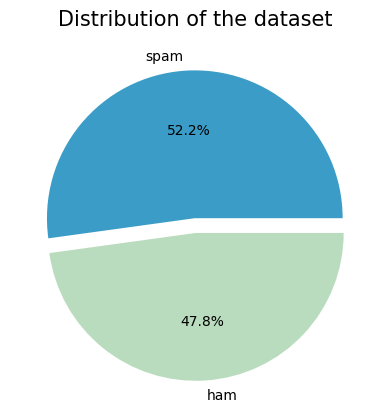

In [61]:
# Representation of the distribution on a pie chart
explode = (0, 0.1)
colors = ['#3b9dc7','#badcbe']
plt.pie(data_analysis['label'].value_counts(), labels=['spam','ham'],autopct='%1.1f%%',colors=colors,explode=explode)
plt.title("Distribution of the dataset",fontsize=15)
plt.show()

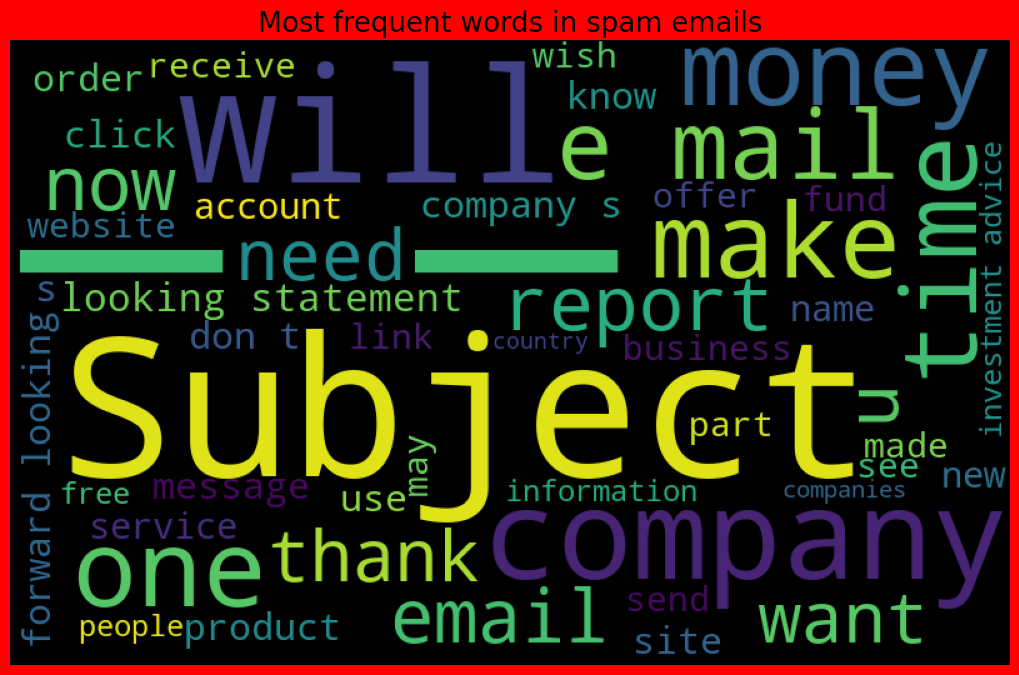

In [62]:
# Getting sense of loud words in spam only

spams = data_analysis['email'][dataset['label']=='spam']
spam_cloud = WordCloud(width=800,height=500,background_color='black',max_words=50).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.title("Most frequent words in spam emails",fontsize=20)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

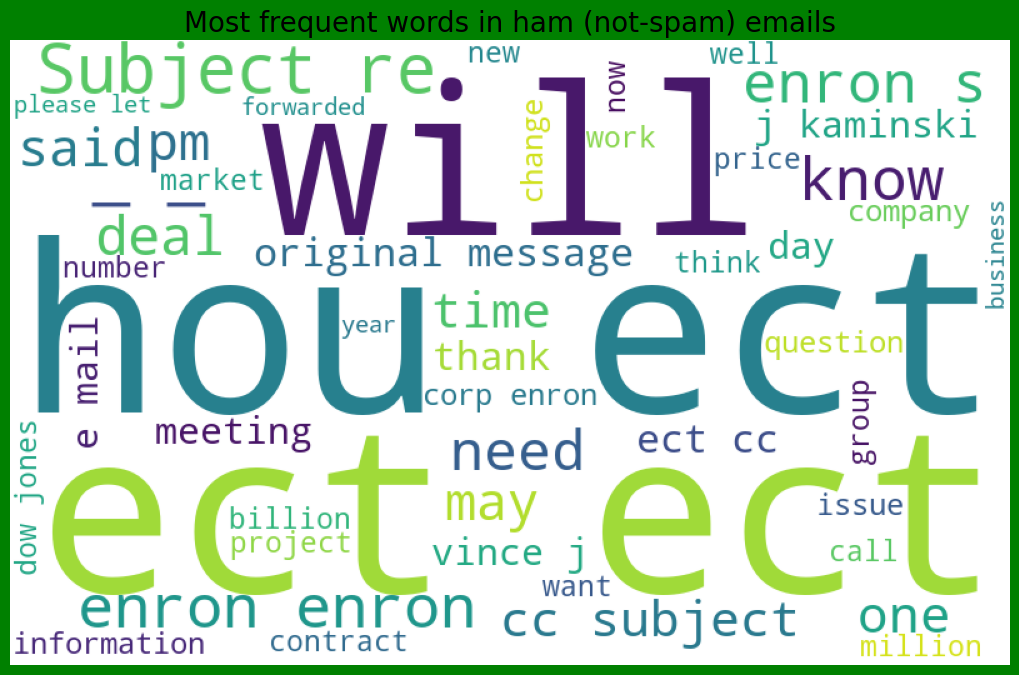

In [63]:
# Getting sense of loud words in ham only

not_spams = data_analysis['email'][dataset['label']=='ham']
spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(not_spams))

plt.figure(figsize=(10,8),facecolor='g')
plt.imshow(spam_cloud)
plt.title("Most frequent words in ham (not-spam) emails",fontsize=20)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Exporting Dataset to CSV

In [64]:
dataset.to_csv("EmailDatasetCleaned.csv", sep=',')